In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Defining and clustering team playing styles

## Data Information

For this first task, two datasets were provided. The former contained information about matches of various competitions during a season (*task1_matches.csv*), while the latter contained all the shots taken throughout those matches by the teams involved (*task1_shots.csv*).

The file *task1_matches.csv* contained a mix of information about the match and aggregated stats of both teams in several matches of different competitions in a season. For each team involved in a match (denoted with the prefixes *home_* and *away_*), the following statistics were provided:
* **goals**: Total number of goals scored by the team in the match (int).
* **mins_ahead**: Total number of minutes during the match that the team was ahead in the scoreboard (double).
* **xpoints**: Average of the points won by the team after simulating the match several times. Based on the goal scoring opportunities of both teams. In a [0, 3] range (double).
* **attack_epv**: Cumulative probability of the attacks ending up in a goal at the instant of the last action (double).
* **attack_duration**: Total effective time that the team possessed the ball. It excludes the time when the game was stopped (double).
* **pct_possession**: Percentage of the possession in a [0, 100] range (double).
* **recoveries_last_third**: Total number of recoveries close to the opponent's goal (int).
* **fouls**: Total number of fouls by the team in the match (int).

The file *task1_shots.csv* contained stats that described each shot taken by the teams involved in the matches of the previous dataset. The following columns were present:
* **match_id**: Internal identifier of the match (string).
* **team_name**: Name of the team that attempted the shot (string).
* **is_goal**: Whether the shot ended up in a goal or not (boolean).
* **is_goal_chance**: Whether the shot is a clear opportunity of scoring a goal or not (boolean).
* **is_header**: Whether the shot is taken with the head or not (boolean).
* **xgoals**: Probability of scoring a goal (computed by an Expected Goals model) given all the information in the instant of the shot (double).
* **shot_pattern**: Type of shot, regarding of how the shot opportunity was created (string).
* **attack_pattern**: Type of attack to which the shot belongs to (string).

## Task Information

Based on this data, I was tasked with defining the style of the teams and grouping them based on their similarity. The following considerations were taken into account:

* Some features might not have been needed or accurate for this task.
* Some features might have provided better information for this problem if they were transformed or combined.
* Both offensive and defensive aspects of the team were considered.

I was given the freedom to use the techniques that I deemed suitable for this task, and it was strongly encouraged to create plots or tables that aided in explaining the results and conclusions.

## Solution

I will devide this section in 2 different process. First I will create a model to cluster the teams based on their general statistics in matches. Secondly, I will analyse the goalscoring aspect of the teams, by finding which are the play patterns where each team is scoring more goals or creating more danger.

### 1. General style idea definition

In [2]:
df_matches = pd.read_csv("task1_matches.csv")

In [3]:
# Remove the erroneous value, home_mins_ahead > 32000, which is for sure incorrect. Later we will input its value with a mean
df_matches.loc[df_matches['home_mins_ahead'] > 100,'home_mins_ahead'] = np.nan
df_matches.loc[df_matches['away_attack_duration'] > 100,'away_attack_duration'] = np.nan

In [4]:
# Fill null values on mins_ahead with 0, where goals = 0
df_matches.loc[(df_matches['home_mins_ahead'].isnull()) & (df_matches['home_goals'] == 0),'home_mins_ahead'] = 0
df_matches.loc[(df_matches['away_mins_ahead'].isnull()) & (df_matches['away_goals'] == 0),'away_mins_ahead'] = 0

In [5]:
# Fill null vallues on draw matches with goals with the avg of drawn matches
df_matches.loc[(df_matches['home_mins_ahead'].isnull()) & (df_matches['home_goals'] == df_matches['away_goals'])
               ,'home_mins_ahead'] = df_matches.loc[(df_matches['home_mins_ahead'].notnull()) & (df_matches['home_goals'] == df_matches['away_goals'])
               ,'home_mins_ahead'].mean()

df_matches.loc[(df_matches['away_mins_ahead'].isnull()) & (df_matches['home_goals'] == df_matches['away_goals'])
               ,'away_mins_ahead'] = df_matches.loc[(df_matches['away_mins_ahead'].notnull()) & (df_matches['home_goals'] == df_matches['away_goals'])
               ,'away_mins_ahead'].mean()

# Do the same for matches where there was a winner
df_matches.loc[(df_matches['home_mins_ahead'].isnull()) & (df_matches['home_goals'] > df_matches['away_goals'])
               ,'home_mins_ahead'] = df_matches.loc[(df_matches['home_mins_ahead'].notnull()) & (df_matches['home_goals'] > df_matches['away_goals'])
               ,'home_mins_ahead'].mean()

df_matches.loc[(df_matches['away_mins_ahead'].isnull()) & (df_matches['home_goals'] > df_matches['away_goals'])
               ,'away_mins_ahead'] = df_matches.loc[(df_matches['away_mins_ahead'].notnull()) & (df_matches['home_goals'] > df_matches['away_goals'])
               ,'away_mins_ahead'].mean()

df_matches.loc[(df_matches['away_mins_ahead'].isnull()) & (df_matches['home_goals'] < df_matches['away_goals'])
               ,'away_mins_ahead'] = df_matches.loc[(df_matches['away_mins_ahead'].notnull()) & (df_matches['home_goals'] < df_matches['away_goals'])
               ,'away_mins_ahead'].mean()

df_matches.loc[(df_matches['home_mins_ahead'].isnull()) & (df_matches['home_goals'] < df_matches['away_goals'])
               ,'home_mins_ahead'] = df_matches.loc[(df_matches['away_mins_ahead'].notnull()) & (df_matches['home_goals'] < df_matches['away_goals'])
               ,'home_mins_ahead'].mean()

# Repeat for attack duration
df_matches.loc[(df_matches['away_attack_duration'].isnull()) & (df_matches['home_goals'] == df_matches['away_goals'])
               ,'away_attack_duration'] = df_matches.loc[(df_matches['away_attack_duration'].notnull()) & (df_matches['home_goals'] == df_matches['away_goals'])
               ,'away_attack_duration'].mean()

df_matches.loc[(df_matches['away_attack_duration'].isnull()) & (df_matches['home_goals'] > df_matches['away_goals'])
               ,'away_attack_duration'] = df_matches.loc[(df_matches['away_attack_duration'].notnull()) & (df_matches['home_goals'] > df_matches['away_goals'])
               ,'away_attack_duration'].mean()

df_matches.loc[(df_matches['away_attack_duration'].isnull()) & (df_matches['home_goals'] < df_matches['away_goals'])
               ,'away_attack_duration'] = df_matches.loc[(df_matches['away_attack_duration'].notnull()) & (df_matches['home_goals'] < df_matches['away_goals'])
               ,'away_attack_duration'].mean()

# If we use describe method before and after, we see there is not a big change difference in the avg 
# df_matches.describe()

In [6]:
# Create columns for win or lost
df_matches['home_win'] = np.where(df_matches['home_goals']>df_matches['away_goals'], 1, 0)
df_matches['away_win'] = np.where(df_matches['home_goals']<df_matches['away_goals'], 1, 0)

In [7]:
# Separate rows into home and away dataframes and create defensive variables
df_matches_home = df_matches[['match_id','competition_name','home_team_name','home_goals','away_goals',
                              'home_mins_ahead','away_mins_ahead','home_xpoints','home_attack_epv','away_attack_epv',
                              'home_attack_duration','away_attack_duration','home_pct_possession',
                              'home_recoveries_last_third','away_recoveries_last_third','home_fouls','away_fouls','home_win']]

df_matches_away = df_matches[['match_id','competition_name','away_team_name','away_goals','home_goals',
                              'away_mins_ahead','home_mins_ahead','away_xpoints','away_attack_epv','home_attack_epv',
                              'away_attack_duration','home_attack_duration','away_pct_possession',
                              'away_recoveries_last_third','home_recoveries_last_third','away_fouls','home_fouls','away_win']]

# Define new names for home matches
columns_home={"away_goals": "goals_conceded","away_mins_ahead": "mins_behind",'away_attack_epv':'defense_epv',
         'away_attack_duration':'defense_duration','away_recoveries_last_third':'losses_first_third','away_fouls':'fouls_drawn'}
df_matches_home = df_matches_home.rename(columns_home, axis=1)
df_matches_home.columns = df_matches_home.columns.str.replace(r'home_', '')

# Define new names for away matches
columns_away={"home_goals": "goals_conceded","home_mins_ahead": "mins_behind",'home_attack_epv':'defense_epv',
         'home_attack_duration':'defense_duration','home_recoveries_last_third':'losses_first_third','home_fouls':'fouls_drawn'}
df_matches_away = df_matches_away.rename(columns_away, axis=1)
df_matches_away.columns = df_matches_away.columns.str.replace(r'away_', '')

# Create column to indicate home or away team
df_matches_home['home_away'] = 'H'
df_matches_away['home_away'] = 'A'

In [8]:
# Now we can observe each team by home matches and by away matches separately, but also want whole picture, so combine them
df_matches_combined = pd.concat([df_matches_home, df_matches_away])
df_matches_combined.head()

match_id competition_name team_name  goals  goals_conceded  \
0  5f5f269bbc7f96139689b855    Competition 1   Team 30      0               2   
1  5f5f269bbc7f96139689b856    Competition 1   Team 57      0               0   
2  5f5f269bbc7f96139689b857    Competition 1   Team 46      2               0   
3  5f5f269bbc7f96139689b859    Competition 1   Team 14      1               1   
4  5f5f269bbc7f96139689b85a    Competition 1   Team 58      4               2   

   mins_ahead  mins_behind  xpoints  attack_epv  defense_epv  attack_duration  \
0    0.000000    88.899333   1.7048    2.105653     1.830109        25.366667   
1    0.000000     0.000000   1.4362    2.072464     2.082875        20.416667   
2   47.716000     0.000000   0.7272    1.817298     2.369569        22.284667   
3   24.883333     0.000000   1.4898    1.885257     1.779448        19.000667   
4   20.132667    13.533333   0.7010    2.414691     3.351247        27.768667   

   defense_duration  pct_possession  recoveries_last_third  \
0         20.318000       55.525559                      1   
1         19.833333       50.724638                      5   
2         31.800000       41.203299                      4   
3         24.450667       43.728616                      1   
4         27.518000       50.226697                      1   

   losses_first_third  fouls  fouls_drawn  win home_away  
0                   4     14           21    0         H  
1                   3     17           13    0         H  
2                   3      8           10    1         H  
3                   7     15           17    0         H  
4                   7      9           14    1         H

In a further analysis, we could try to find differences between home and away matches with the 2 different datasets

In [9]:
# df_team_stats = df_matches_combined.groupby('team_name').mean()                             # To look at the global picture
# df_team_stats = df_matches_home.drop('home_away',axis=1).groupby('team_name').mean()        # To look only from home games
# df_team_stats = df_matches_away.drop('home_away',axis=1).groupby('team_name').mean()        # To look only from away games

# We drop columns that do not provide useful information about the style of play, rather about the results and global picture
df_team_stats = df_matches_combined.drop(['mins_ahead','mins_behind','xpoints','win'],axis=1).groupby('team_name').mean()
df_team_stats.head()

goals  goals_conceded  attack_epv  defense_epv  attack_duration  \
team_name                                                                       
Team 1     1.526316        0.947368    2.725532     1.915647        33.807140   
Team 10    1.763158        0.736842    2.870840     2.112164        33.690053   
Team 11    1.000000        1.764706    2.321313     2.695135        25.740863   
Team 12    2.911765        1.294118    3.434667     2.246325        35.472471   
Team 13    0.868421        1.447368    2.242823     2.779463        23.203140   

           defense_duration  pct_possession  recoveries_last_third  \
team_name                                                            
Team 1            24.715070       57.968638               4.157895   
Team 10           24.504053       57.921289               4.578947   
Team 11           30.554078       45.971645               3.941176   
Team 12           23.364588       60.351895               7.970588   
Team 13           31.723807       42.438863               4.578947   

           losses_first_third      fouls  fouls_drawn  
team_name                                              
Team 1               4.815789  11.394737     9.921053  
Team 10              3.789474  10.710526    12.973684  
Team 11              4.176471  12.411765    13.500000  
Team 12              3.823529   9.323529    11.676471  
Team 13              2.552632  10.105263    10.605263

Since we have too many variables to be able to show, I will apply PCA. In order to do that, I first need to find the optimal number of components.

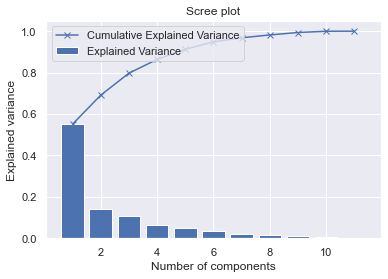

In [10]:
# We first apply a Min-Max scaler to scale all the columns between 0,1
scaler = MinMaxScaler()
scaler.fit(df_team_stats)
df_team_stats_scaled=scaler.transform(df_team_stats)
x_scaled = df_team_stats_scaled
 
# Reduce features with PCA
pca = PCA(n_components=11)
 
# Fit and transform data
reduced_features = pca.fit_transform(x_scaled)
 
# Bar plot of percentage of explained_variance, and select num of components by obtaining around 80% var
sns.set()
p_explained = pca.explained_variance_/np.sum(pca.explained_variance_)
plt.bar(range(1,len(pca.explained_variance_ )+1),p_explained,label='Explained Variance')
plt.plot(range(1,len(pca.explained_variance_ )+1),np.cumsum(p_explained),label='Cumulative Explained Variance',marker='x')
plt.legend(loc='upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.title('Scree plot')
plt.show()

In the above plot, it is shown the percentage of explained variance by each principal component. It is normally expected to take the number of PCs corresponding to around 80% of the variance. In this case, with 3 PCs we would approximately comply with this. Therefore, we will need to work in 3D in order to show all the findings.

### Clustering with KMeans

After determining the workspace and dimensions we will work on, the goal is to cluster the different teams, in this case I will use a simple KMeans clustering model. Again, I will need to find the optimal number of clusters with the elbow method.

C:\Users\Alex\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


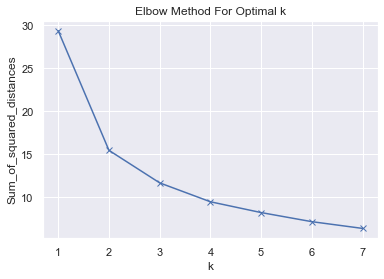

In [11]:
# This should solve warning error below -> If not run "%matplotlib jupyter" in a cell and then back again ""%matplotlib inline"
import os
os.environ["OMP_NUM_THREADS"] = '1'

# We scale data to improve performance bevcause of different value ranges
scaler = MinMaxScaler()
scaler.fit(df_team_stats)
df_team_stats_scaled=scaler.transform(df_team_stats)

# Perform PCA
pca = PCA(3)
df_pca = pca.fit_transform(df_team_stats_scaled)

Sum_of_squared_distances = []
K = range(1,8)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_pca)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In the plot above, and with the use of the elbow method, I determine that 4 should be the best number of clusters for our use case.

Finally, once we have the optimal number of dimensions and clusters, we finally apply the model to find the team clusterings:

Below cell may need to be run twice for the interactive plot to appear

<IPython.core.display.Javascript object>


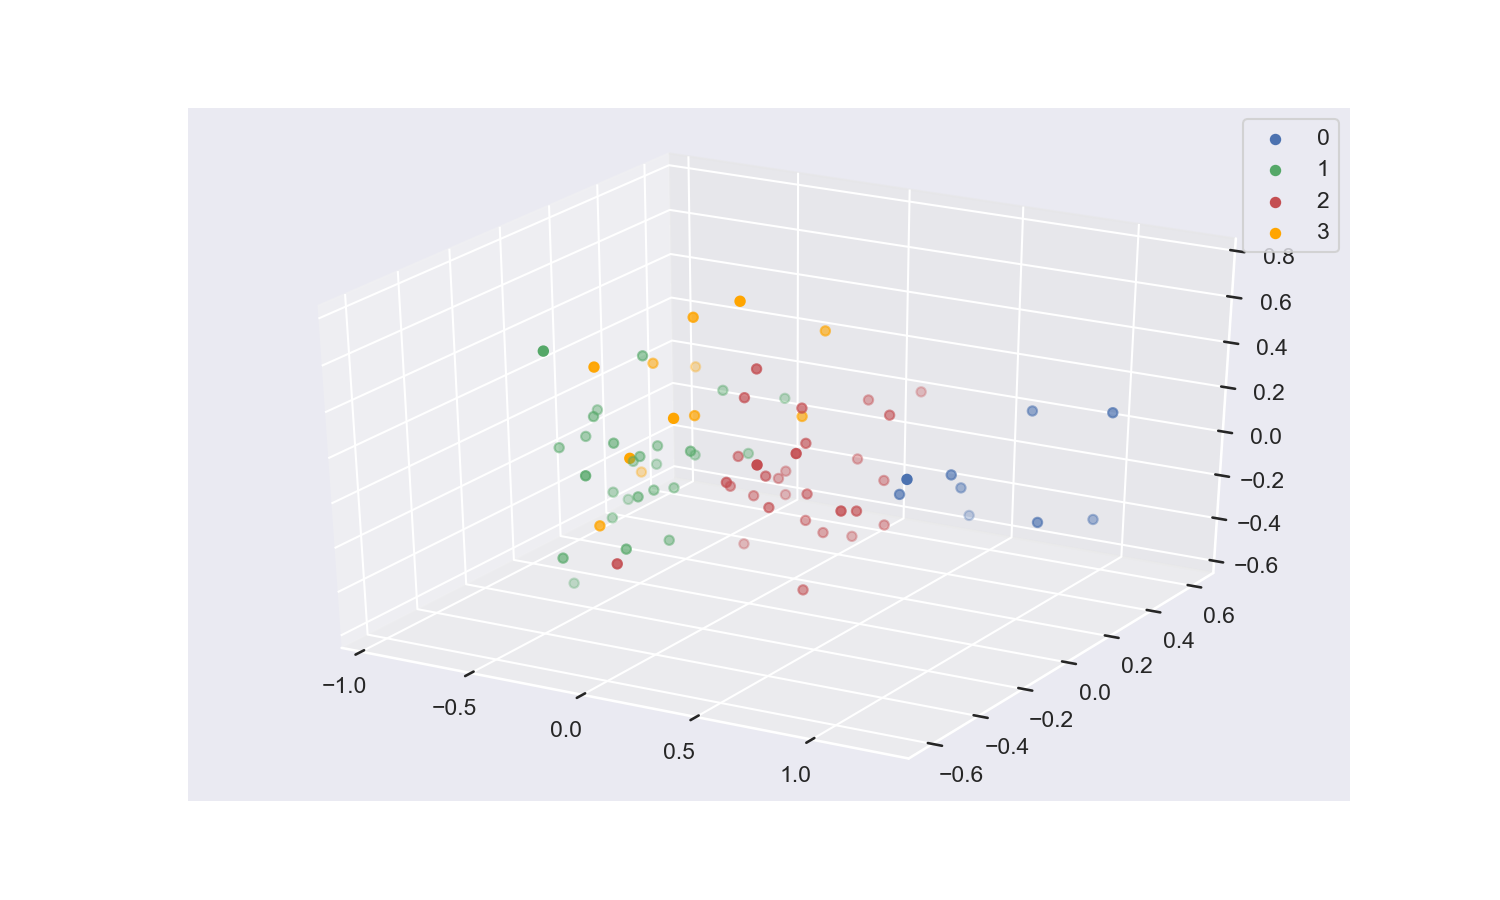

In [12]:
%matplotlib notebook

scaler = MinMaxScaler()
scaler.fit(df_team_stats)
df_team_stats_scaled=scaler.transform(df_team_stats)

# Perform PCA
pca = PCA(3)
df_pca = pca.fit_transform(df_team_stats_scaled)
 
# Predict the labels of clusters
kmeans = KMeans(n_clusters= 4)
label = kmeans.fit_predict(df_pca)
 
# Getting unique labelsfe
u_labels = np.unique(label)
 
# Plotting the results:
sns.set(rc={'figure.figsize':(10,6)})
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
c = ['b','g','r','orange']

for i in u_labels:
    ax.scatter3D(df_pca[label == i, 0], df_pca[label == i, 1], df_pca[label == i, 2], label=i, color=c[i])
plt.legend()
plt.show()

To check each individual set of PCs:

<IPython.core.display.Javascript object>


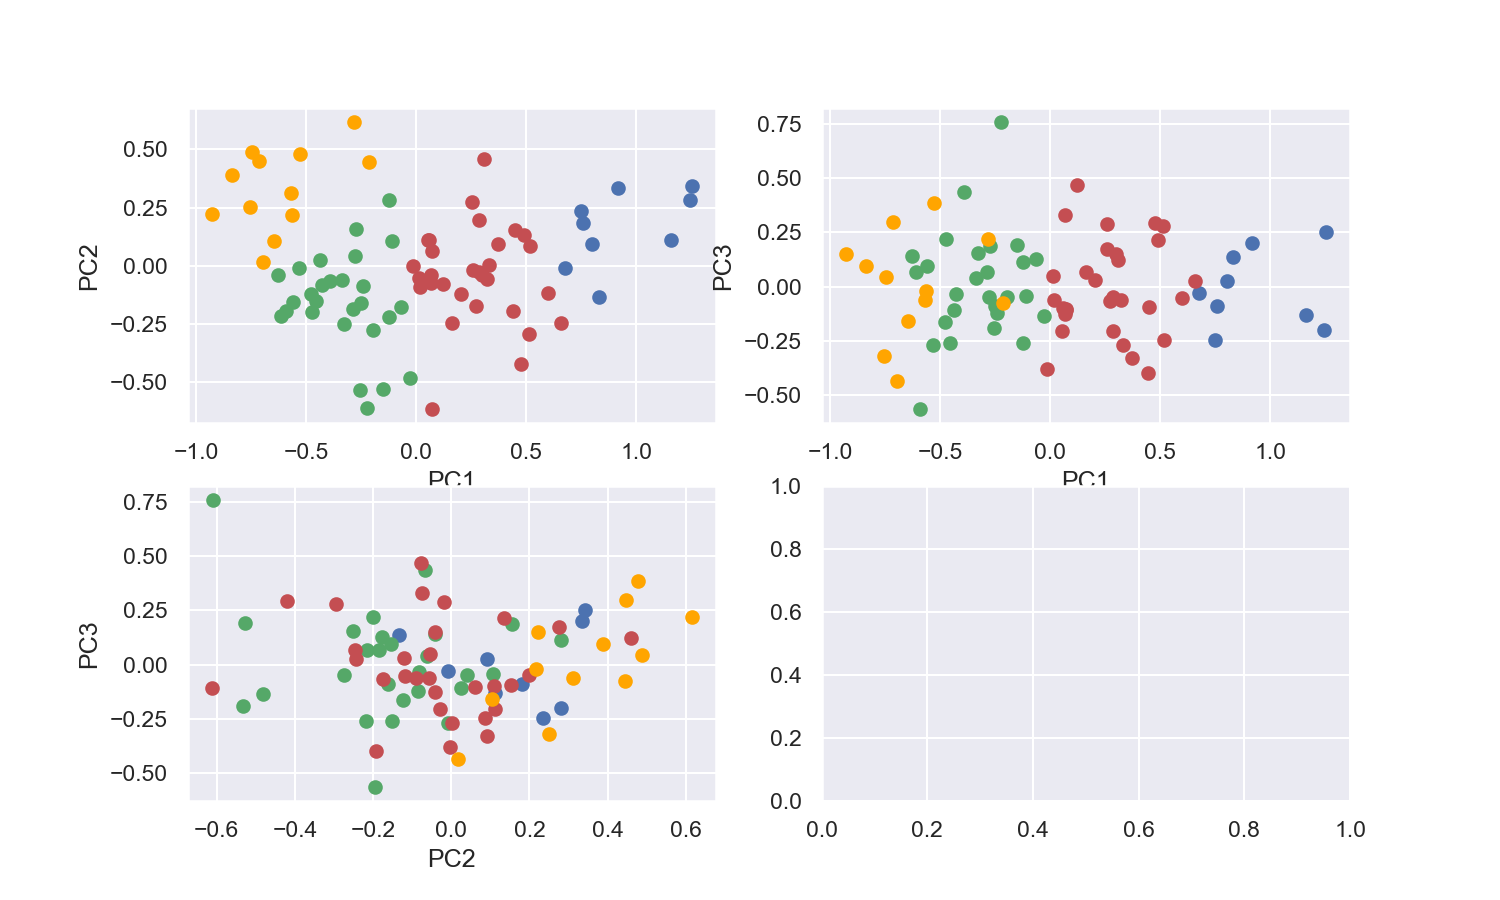

Text(0, 0.5, 'PC3')

In [13]:
fig, axes = plt.subplots(2, 2)

for i in u_labels:
    axes[0,0].scatter(df_pca[label == i, 0], df_pca[label == i, 1], label=i, color=c[i])
    axes[0,1].scatter(df_pca[label == i, 0], df_pca[label == i, 2], label=i, color=c[i])    
    axes[1,0].scatter(df_pca[label == i, 1], df_pca[label == i, 2], label=i, color=c[i])  
    
axes[0,0].set_xlabel('PC1')
axes[0,0].set_ylabel('PC2')
axes[0,1].set_xlabel('PC1')
axes[0,1].set_ylabel('PC3')
axes[1,0].set_xlabel('PC2')
axes[1,0].set_ylabel('PC3')

### Biplots

Now that we have all the teams in each different cluster, we need to find out what each cluster is defined by. For this I will be using a 3D Biplot and 3 different ones for each combination of PCs.

<IPython.core.display.Javascript object>


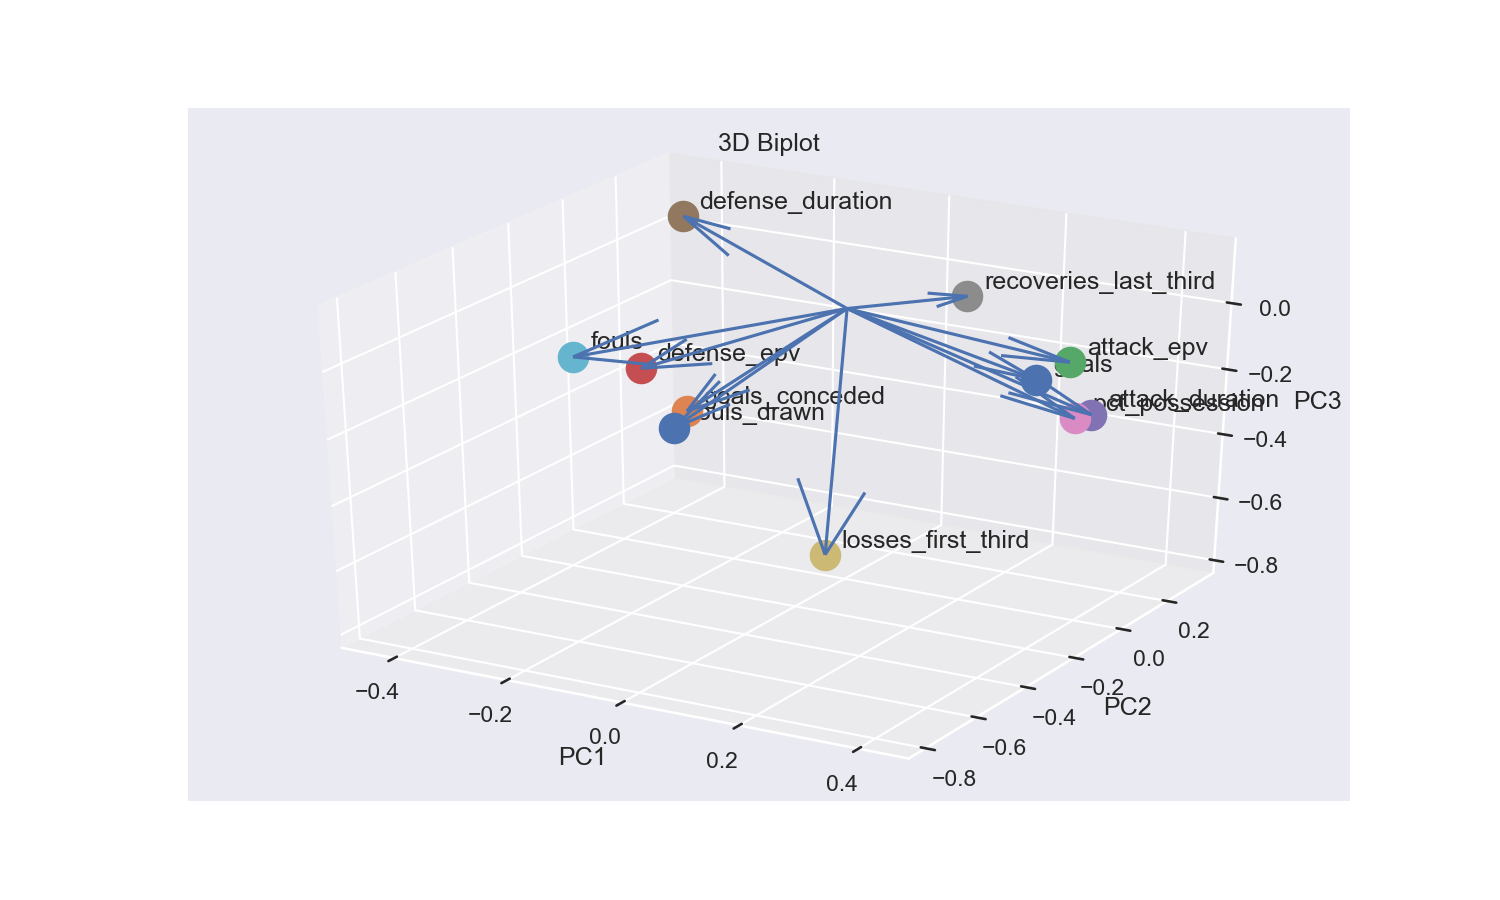

In [14]:
# Principal components correlation coefficients
loadings = pca.components_
 
# Number of features before PCA
n_features = pca.n_features_
 
# Feature names before PCA
feature_names = pd.DataFrame(df_team_stats).columns

# PC names
pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]
 
# Match PC names to loadings
pc_loadings = dict(zip(pc_list, loadings))
 
# Matrix of corr coefs between feature names and PCs
loadings_df = pd.DataFrame.from_dict(pc_loadings)
loadings_df['feature_names'] = feature_names
loadings_df = loadings_df.set_index('feature_names')

# Get the loadings of x and y axes
xs = loadings[0]
ys = loadings[1]
zs = loadings[2]

# Create figure
sns.set(rc={'figure.figsize':(10,6)})
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the loadings on a scatterplot
for i, varnames in enumerate(feature_names):
        ax.scatter(xs[i], ys[i], zs[i], s=200)
        ax.text(xs[i]+0.02, ys[i]+0.02, zs[i]+0.02, varnames)
    
# Plot the arrows
x_arr = np.zeros(len(loadings[0]))
y_arr = z_arr = x_arr
ax.quiver(x_arr, y_arr, z_arr, xs, ys, zs)

# Define the axes
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
 
# Show plot
plt.title('3D Biplot')
plt.show()

Now I include the teams scatterplot together with the Biplot, so we can explain them.

<IPython.core.display.Javascript object>


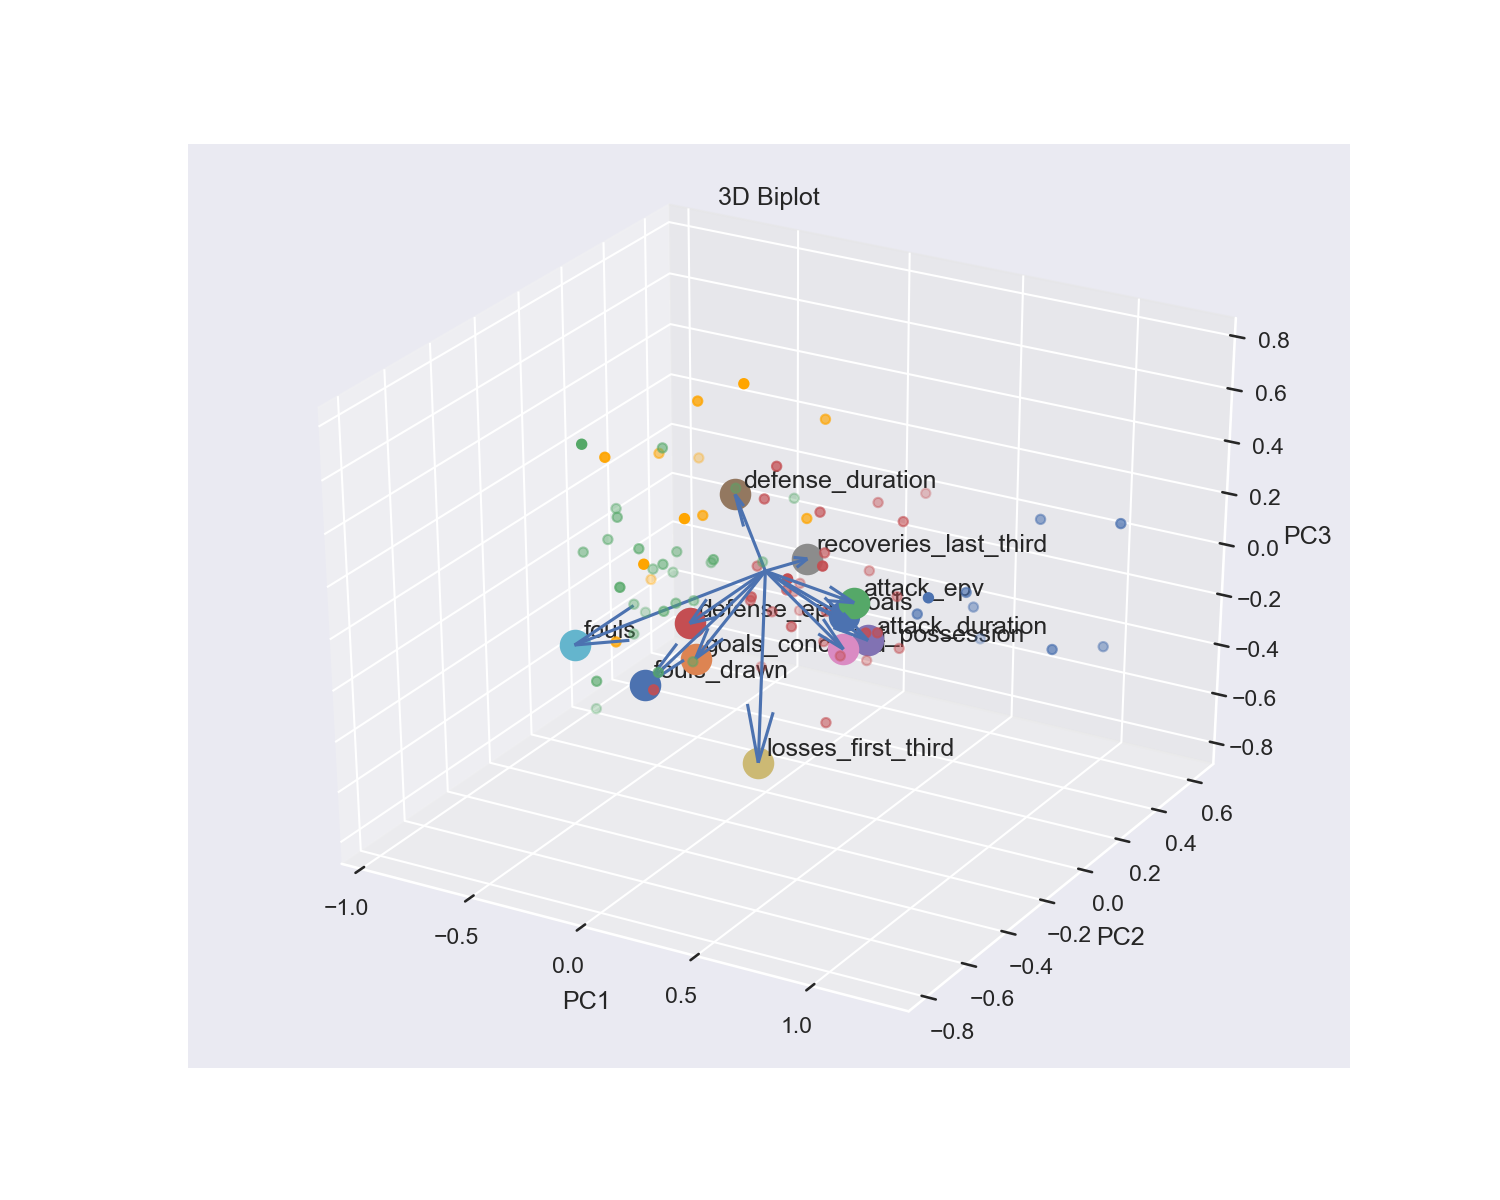

In [15]:
# Get the loadings of x and y axes
xs = loadings[0]
ys = loadings[1]
zs = loadings[2]

# Create dataframee with values and label related to each team
pca_df_scaled = pd.DataFrame(data=df_pca, columns=['PC1', 'PC2', 'PC3'],index=df_team_stats.index)
pca_df_scaled['label'] = label

# Create figure
sns.set(rc={'figure.figsize':(10,8)})
sns.color_palette("tab10")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the loadings on a scatterplot
for i, varnames in enumerate(feature_names):
        ax.scatter(xs[i], ys[i], zs[i], s=200)
        ax.text(xs[i]+0.02, ys[i]+0.02, zs[i]+0.02, varnames)
    
# Plot the arrows
x_arr = np.zeros(len(loadings[0]))
y_arr = z_arr = x_arr
ax.quiver(x_arr, y_arr, z_arr, xs, ys, zs)

# Plot the teams
x=pca_df_scaled['PC1']
y=pca_df_scaled['PC2'] 
z=pca_df_scaled['PC3']

for i in u_labels:
    ax.scatter3D(df_pca[label == i, 0], df_pca[label == i, 1], df_pca[label == i, 2], label=i, color=c[i])

# Define the axes
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
 
# Show plot
plt.title('3D Biplot')
plt.show()

<IPython.core.display.Javascript object>


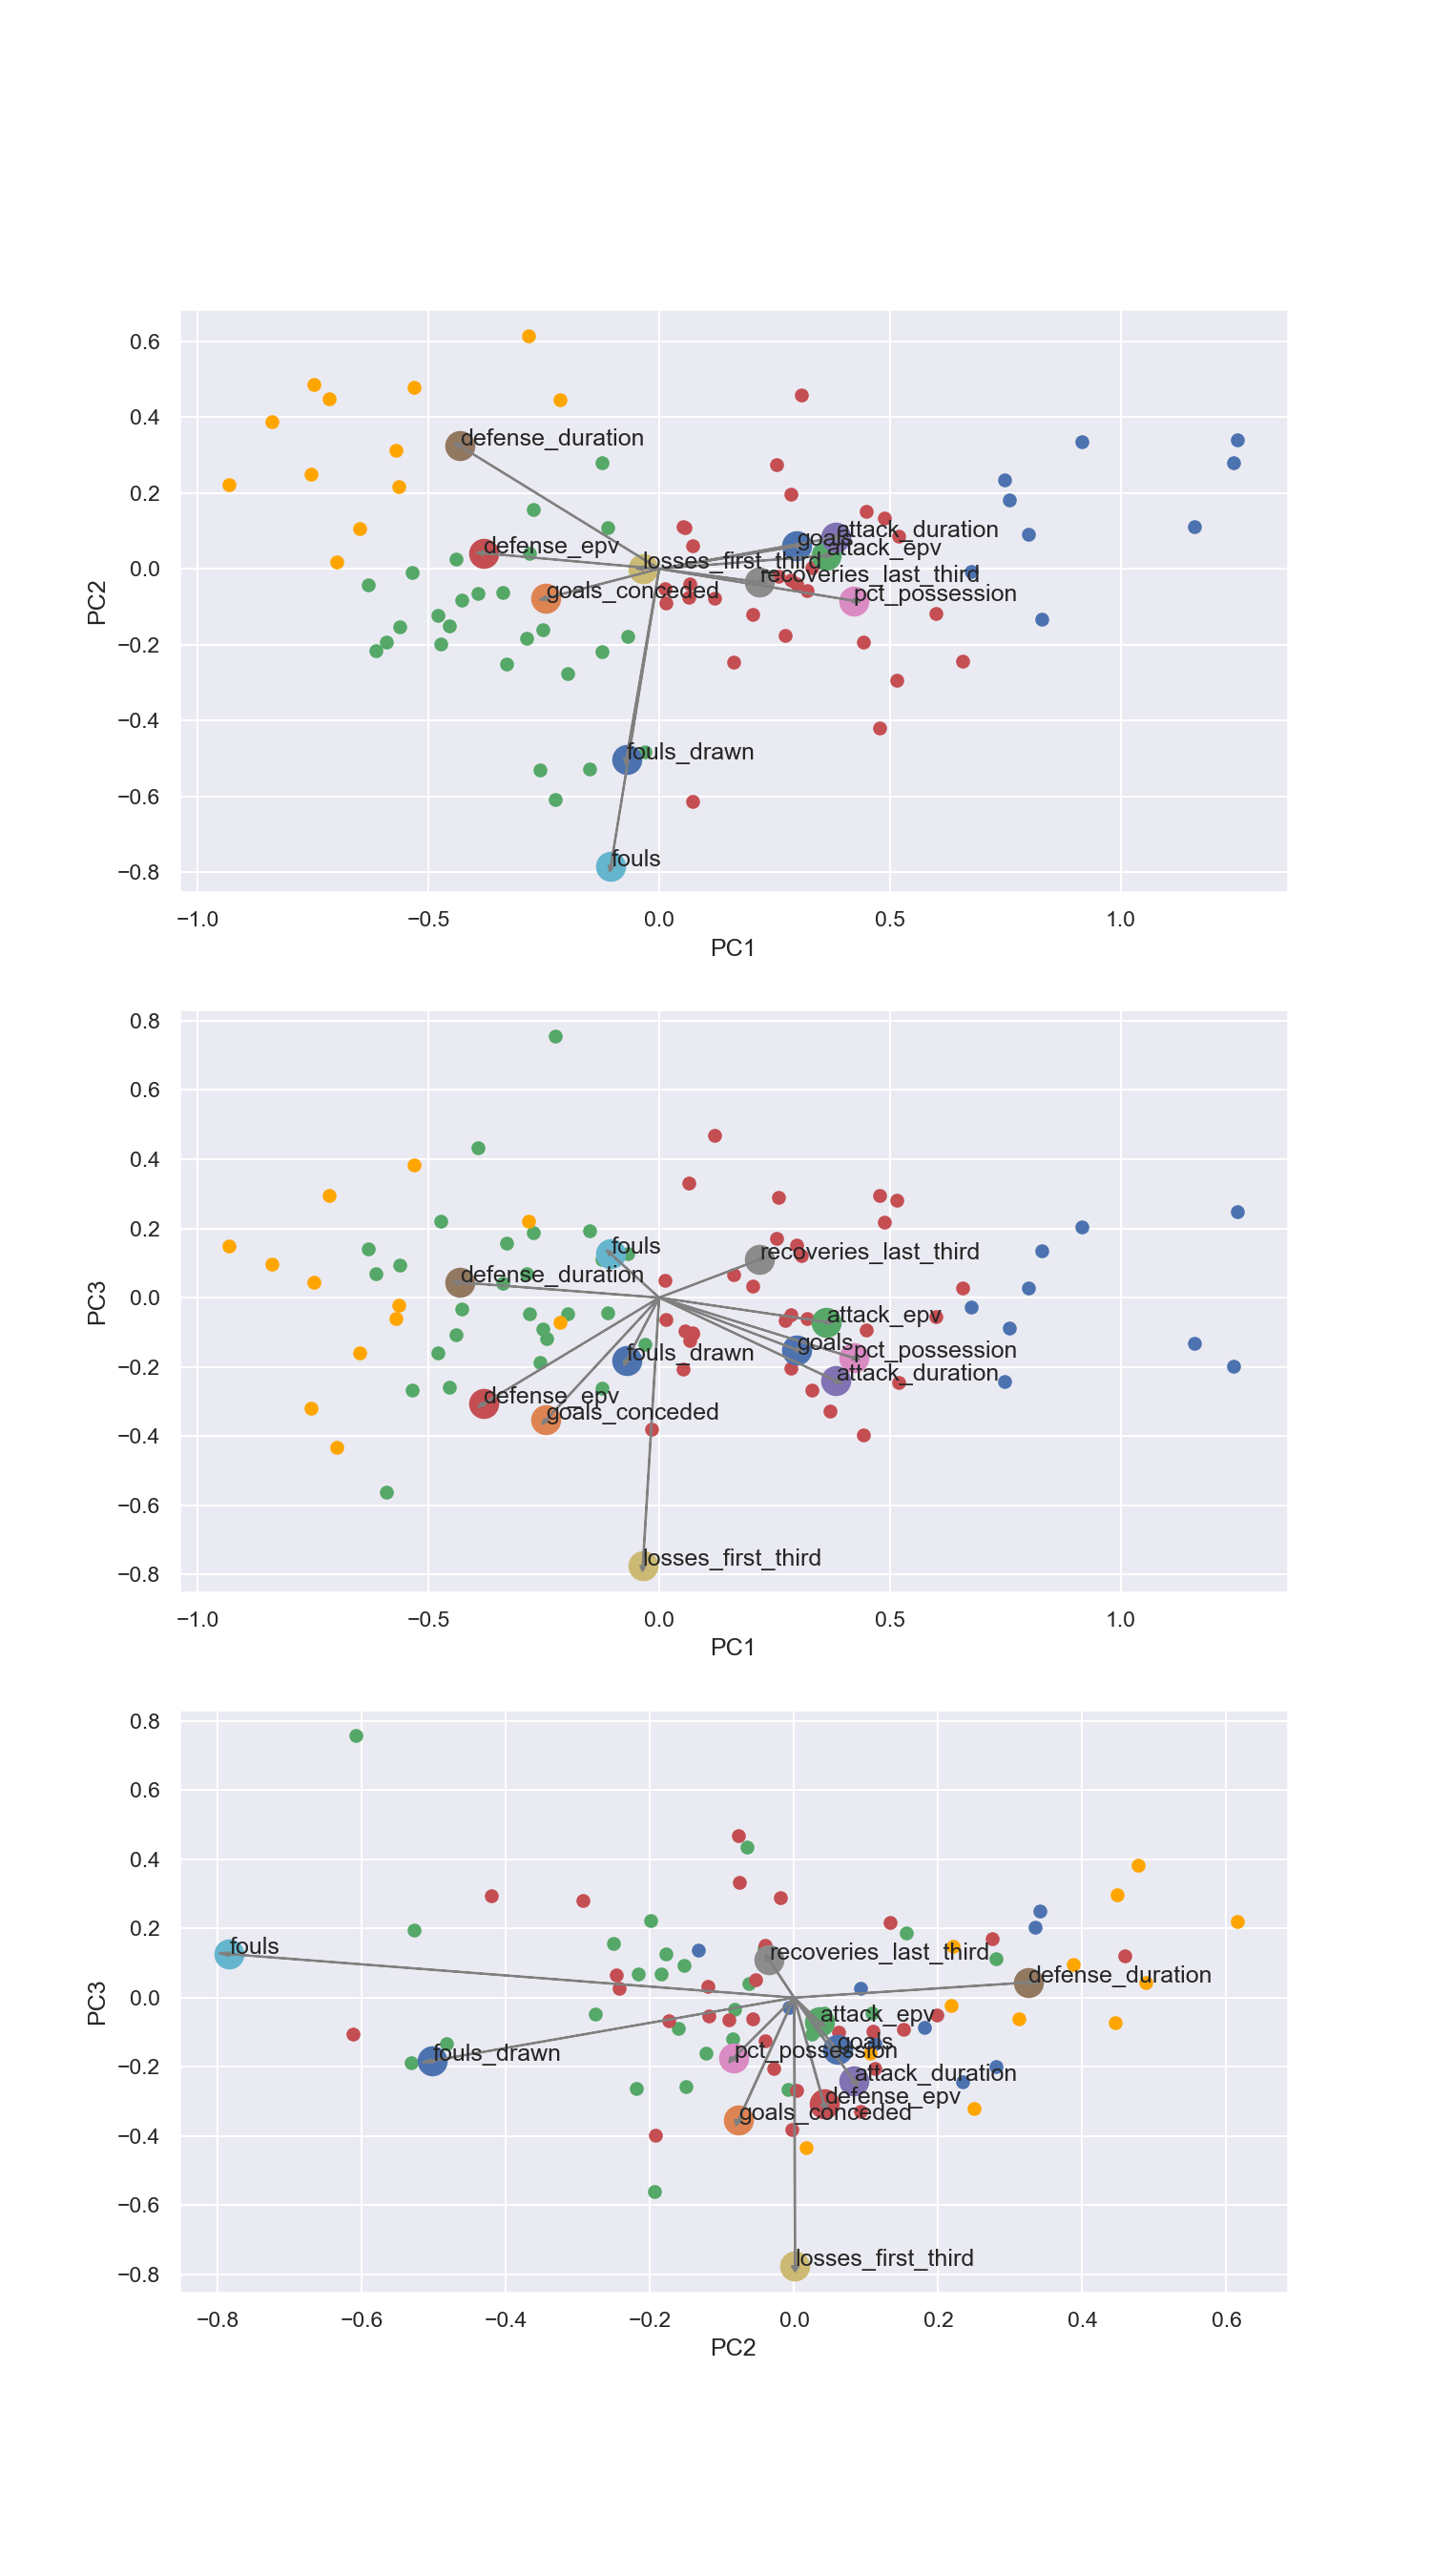

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(10,18))

for i in u_labels:
    axes[0].scatter(df_pca[label == i, 0], df_pca[label == i, 1], label=i, color=c[i])
    axes[1].scatter(df_pca[label == i, 0], df_pca[label == i, 2], label=i, color=c[i])    
    axes[2].scatter(df_pca[label == i, 1], df_pca[label == i, 2], label=i, color=c[i])  
    
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC3')
axes[2].set_xlabel('PC2')
axes[2].set_ylabel('PC3')

# Plot the loadings on a scatterplot
for i, varnames in enumerate(feature_names):

    axes[0].scatter(xs[i], ys[i], s=200)
    axes[0].text(xs[i], ys[i], varnames)
    axes[1].scatter(xs[i], zs[i], s=200)
    axes[1].text(xs[i], zs[i], varnames)
    axes[2].scatter(ys[i], zs[i], s=200)
    axes[2].text(ys[i], zs[i], varnames)
    axes[0].arrow(
            0, 0, # coordinates of arrow base
            xs[i], # length of the arrow along x
            ys[i], # length of the arrow along y
            color='grey', 
            head_width=0.01
            )
    axes[1].arrow(
            0, 0, # coordinates of arrow base
            xs[i], # length of the arrow along x
            zs[i], # length of the arrow along y
            color='grey', 
            head_width=0.01
            )
    axes[2].arrow(
            0, 0, # coordinates of arrow base
            ys[i], # length of the arrow along x
            zs[i], # length of the arrow along y
            color='grey', 
            head_width=0.01
            )

### Clustering analysis

With all the previous plots, specially with the Diplot + Team clusterings basen on PC1 and PC2 plot, I believe we can start to define each type of teams. As we selected 4 clusters, we are going to have 4 different style of plays.

I consider there are 4 distinction between them and it could even be separated from weaker to stronger teams and/or from more defensive to more offensive teams, and that is the order I will take.

    - Type 0 (Blue)
These teams are defined by their defensive style of play. They tend to spend a lot of time defending and tend to have their defensive lines tightly put in the back (high values of defense_duration and low recoveries_last_third) and still they tend to have not very strong defensed because they also tends to concede a bigger amount of goals (high value of defense_epv and goals_conceded). Moreover, as seen in the plot, they do not tend to have good number in the offensive statistics (attack_duration, attack_epv, pct_possesion, goals)

As a side note, they do not tend to do or receive that many fouls. So even though they defend a lot, they do not have hard or agressive defending.

    - Type 2 (Red)
As with the last group, they are also quite defensive teams. They have very similar statistics from goal perspective. Nevertheless, they tend to have a bit more posession.

The distinctive aspect, is that they are way more agressive, they commit and draw a lot more fouls, and recover more balls in the last third, which could imply that they are more aggresive in both their physical ans stretegical aspect. So they may have higher unorganized pressure and when they get surpassed they may make fouls to stop the opponent from advancing. They also may not have build-ups from the back since they are the type with less losses in first third.

    - Type 1 (Green)
These teams are already more offense oriented, they are better in scoring and making the most of their chances and defending the opponents. They try to control the ball, even though this may cause them to lose more balls in the first third than what is optimal. This teams already have more orrganized pressures in when the other team is in build-up phase which explains the big increase in recoveries last third and the smaller amount of fouls, which is in an intermediate level between the first two.
   
    - Type 3 (Orange)
In my opinion these are the best and more offensive teams. They like to control the ball and have good ability in doing it so. They score more goals, attack more, have more posession and the least amount of losses in build-up. On the contrary, they concede less goals, spend less time in defense because they have the control of the ball the majority of time. Furthermore, they will always try to make the game as fluent as possible by trying not to be making or drawing too many fouls which may stop the pace of the game and turning into slow-paced games.

### Radar chart analysis

I will now create a radar chart with the different cluster values to see the main characteristics of each group of teams, where they excel and where they are weak.

In [17]:
# Show mean statistics for each cluster
df_team_stats['label'] = pca_df_scaled['label']
df_team_stats_label = df_team_stats.groupby(df_team_stats.label).mean()
df_team_stats_label

goals  goals_conceded  attack_epv  defense_epv  attack_duration  \
label                                                                       
0      1.993464        1.040764    2.994674     2.069085        34.988711   
1      1.129056        1.580839    2.268764     2.581517        25.756553   
2      1.648710        1.268421    2.595500     2.342784        29.565420   
3      1.003225        1.651961    2.132379     2.754667        24.171433   

       defense_duration  pct_possession  recoveries_last_third  \
label                                                            
0             24.156786       59.098168               5.187307   
1             29.175504       47.002341               3.557448   
2             26.623155       52.689571               4.179618   
3             31.958399       43.197179               3.053922   

       losses_first_third      fouls  fouls_drawn  
label                                              
0                3.727554  10.759202    11.414001  
1                3.916351  13.779096    13.478443  
2                3.952270  12.662281    12.498039  
3                3.909572  11.027993    11.623968

In [18]:
# Create a scaled view of the previous dataframe so that it can be shown properly in a radar chart
df_scaled_label = df_team_stats.copy().drop(['label'] ,axis=1)
df_scaled_label = pd.DataFrame(df_team_stats_scaled, columns=df_scaled_label.columns, index=df_scaled_label.index)
df_scaled_label['label'] = pca_df_scaled['label']
df_team_stats_scaled_label = df_scaled_label.groupby(df_scaled_label.label).mean()
df_team_stats_scaled_label

goals  goals_conceded  attack_epv  defense_epv  attack_duration  \
label                                                                       
0      0.615041        0.204577    0.712127     0.268334         0.818546   
1      0.252674        0.493153    0.237188     0.718110         0.304619   
2      0.470517        0.326220    0.450961     0.508567         0.516647   
3      0.199924        0.531155    0.147956     0.870089         0.216380   

       defense_duration  pct_possession  recoveries_last_third  \
label                                                            
0              0.120286        0.885126               0.518994   
1              0.593396        0.372981               0.237322   
2              0.352788        0.613782               0.344846   
3              0.855738        0.211868               0.150303   

       losses_first_third     fouls  fouls_drawn  
label                                             
0                0.511765  0.217781     0.393127  
1                0.563010  0.621851     0.630851  
2                0.572759  0.472418     0.517956  
3                0.561169  0.253746     0.417305

In [19]:
# We create the radar chart to show the difference in characteristics of each cluster of teams
data = df_team_stats_scaled_label

plot_data = []
columns = list(data.columns)
columns = [*columns]

names = list(data.index)
names = [*(names)]
str_names = [str(x) for x in names]

colors = ['blue','green','red','orange']

for name in names:
    plot_data.append(go.Scatterpolar(r=data.T[name], theta=columns, name=name, fillcolor=colors[name],opacity=0.3,fill='toself'))

fig = go.Figure(
    data = plot_data,
    layout=go.Layout(
        title=go.layout.Title(text='Team comparison'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True,
        plot_bgcolor='rgba(0,0,0,0)'
    )
)
fig.update_traces(fill='toself')
fig.show()

With the above dataframes and with the help of this visual, I think my explanations above can be perceived in a more visual and effective way. (For color references, please look into the fill color, not the line color)

### 2. Goalscoring analysis

Now I will focus on the goalscoring characteristics of each team. For this I will create a simple table that shows for each team, which are the 3-6 most common patterns when scoring goals. I will show which are the actions where the team has gotten the most goals, and which are the ones where the xgoals is also high. Because sometimes from some action a team may not be making the most out of them until now but still they can create a lot of damage with those actions.

#### Clean dataset

In [20]:
df_shots = pd.read_csv("task1_shots.csv")
df_shots.head()

match_id team_name  is_goal is_goal_chance is_header  \
0  60867a67c794673084cb4655   Team 13    False           True      True   
1  6059b492c79467abbec565cb   Team 34    False          False     False   
2  6059b492c79467abbec565ef   Team 17     True           True     False   
3  5fec4215c794678aa24c23d1   Team 66    False          False     False   
4  601d0397c7946797b9d71b94    Team 1    False          False      True   

     xgoals     shot_pattern attack_pattern  
0  0.057035              NaN            NaN  
1  0.001114  Outside the box      Set piece  
2  0.119692   Driving to box      Set piece  
3  0.016168  Outside the box      Set piece  
4  0.045325            Cross      Set piece

In [21]:
# Drop rows with missing values now that we have only a few of them
df_shots_clean = df_shots[df_shots['attack_pattern'].notna()]
df_shots_clean = df_shots_clean[df_shots_clean['xgoals'].notna()]
df_shots_clean = df_shots_clean[df_shots_clean['is_goal_chance'].notna()]

In [22]:
# Convert variables into true binary (0,1 instead True,Faslse)
df_shots_clean['is_goal_chance'] = np.where(df_shots_clean['is_goal_chance'] == True,1,0)
df_shots_clean['is_goal'] = np.where(df_shots_clean['is_goal'] == True,1,0)
df_shots_clean['is_header'] = np.where(df_shots_clean['is_header'] == True,1,0)

df_shots_clean['is_shot'] = 1
df_shots_clean.head()

match_id team_name  is_goal  is_goal_chance  is_header  \
1  6059b492c79467abbec565cb   Team 34        0               0          0   
2  6059b492c79467abbec565ef   Team 17        1               1          0   
3  5fec4215c794678aa24c23d1   Team 66        0               0          0   
4  601d0397c7946797b9d71b94    Team 1        0               0          1   
5  6059b492c79467abbec5662d   Team 32        1               1          0   

     xgoals          shot_pattern attack_pattern  is_shot  
1  0.001114       Outside the box      Set piece        1  
2  0.119692        Driving to box      Set piece        1  
3  0.016168       Outside the box      Set piece        1  
4  0.045325                 Cross      Set piece        1  
5  0.103702  Pass outside the box      Set piece        1

In [23]:
# Creat textual variable for the next analysis: Data Mining
df_dummy = df_shots_clean.copy()
df_dummy['is_goal_chance'] = np.where(df_dummy['is_goal_chance'] == True,'Goal Chance','Not Goal Chance')
df_dummy['is_goal'] = np.where(df_dummy['is_goal'] == True,'Goal','Not Goal')
df_dummy['is_header'] = np.where(df_dummy['is_header'] == True,'Header','Not Header')

df_dummy.head()

match_id team_name   is_goal   is_goal_chance   is_header  \
1  6059b492c79467abbec565cb   Team 34  Not Goal  Not Goal Chance  Not Header   
2  6059b492c79467abbec565ef   Team 17      Goal      Goal Chance  Not Header   
3  5fec4215c794678aa24c23d1   Team 66  Not Goal  Not Goal Chance  Not Header   
4  601d0397c7946797b9d71b94    Team 1  Not Goal  Not Goal Chance      Header   
5  6059b492c79467abbec5662d   Team 32      Goal      Goal Chance  Not Header   

     xgoals          shot_pattern attack_pattern  is_shot  
1  0.001114       Outside the box      Set piece        1  
2  0.119692        Driving to box      Set piece        1  
3  0.016168       Outside the box      Set piece        1  
4  0.045325                 Cross      Set piece        1  
5  0.103702  Pass outside the box      Set piece        1

### Application of Data Mining: Apriori Algorithm

This algorithm tries to find frequent itemsets in a list of transaction. In this case a transaction is a list of descriptions of the shots. For example a transaction could be: [Team 2, Goal, Header]. Apriori algorithm will show a set of rules and in each of them it tells how frequent this itemset is in the global dataset of transactions (support[0,1]), how confident is the algorithm on this rule being relevant/frequent (confidence[0,1]) and how much the elements of the transaction are correlated (lift[0,inf]. A value of >= 1 means already a correlation, and the higher the more correlated they are).

In [24]:
from apyori import apriori # Implementation of the algorithm
def print_apyori_output (association_results, conditions):              # This function helps print the best rules.
    for relation_record in association_results:
        itemset = list(relation_record.items)
        
        # Consider only itemsets of two elements
        if len(itemset) > 2: 
#                 if conditions == [] or set(conditions) == set(itemset):   # By inclusing thhis line you can set conditions
                print("Rules involving itemset %s" % itemset)
                support = relation_record.support

                for rules in relation_record.ordered_statistics:
                    antecedent = list(rules.items_base)
                    consequent = list(rules.items_add)
                    confidence = rules.confidence
                    lift = rules.lift

                    print("%s => %s (support=%.2f, confidence=%.2f, lift=%.2f)" %
                          (antecedent, consequent, support, confidence, lift))
                print()

In this case I choose a random team from the 78 teams that we will focus on. In this case I select 'Team 2', but feel free to play with the thresholds and the team selection

In [25]:
team = 'Team 2'
min_support=0.1
min_confidence=0.7
min_lift=5

In [26]:
# We create transactions data
df_dummy_team = df_dummy[df_dummy['team_name']==team]
df_team_patterns = df_dummy_team['shot_pattern'] + ',' + df_dummy_team['attack_pattern'] + ',' +\
                    df_dummy_team['is_goal_chance'] + ',' + df_dummy_team['is_goal'] + ',' + df_dummy_team['is_header']
df_team_patterns_transactions = df_team_patterns.str.split(',').to_list()

# We apply algorithm and print results
results = apriori(df_team_patterns_transactions, min_support=min_support, min_confidence=min_confidence, min_lift=min_lift)


print_apyori_output(results,[team])   # Uncomment line in the above function and put conditions in this list, to condition

                                      # Example of conditioned rules: print_apyori_output(results,[team,'Goal','Not Header'])

Rules involving itemset ['Cross', 'Header', 'Not Goal']
['Header'] => ['Cross', 'Not Goal'] (support=0.11, confidence=0.83, lift=5.60)
['Cross', 'Not Goal'] => ['Header'] (support=0.11, confidence=0.71, lift=5.60)
['Header', 'Not Goal'] => ['Cross'] (support=0.11, confidence=0.86, lift=5.63)

Rules involving itemset ['Cross', 'Regular play', 'Header']
['Header'] => ['Cross', 'Regular play'] (support=0.10, confidence=0.80, lift=5.88)
['Cross', 'Regular play'] => ['Header'] (support=0.10, confidence=0.75, lift=5.88)
['Regular play', 'Header'] => ['Cross'] (support=0.10, confidence=0.89, lift=5.80)



By adjusting the 3 different thresholds, I get this set of rules. I have chosen a set of thresholds that only provides rules with 1 single itemset to focus more on the explanation, but we could get as many as we want and we could even put some conditions on what items we want to appear in the rules.

For this case, we see that one of the best rules, is ['Cross', 'Regular play'] => ['Header'], which means that with these items appearing together in 10% of Team's 2 total shots, and a high correlation (lift=5.88); the confidence that a Cross coming from a Regular play, the probability of that shot being a header is 75%. By looking at the table below, we can see that it makes a lot of sense. We see it in the _is_header_pct in the Regular play Crosses, which is 24/32=75%. But this is a good method of finding the most relevant rules for any team that we want without having to look into all the numbers in the table.

By putting conditions on the items in the rules, we could even choose to focus on a certain aspect of the game, for example checking if a team is capable of creating clear choices from headers, and if that is a weakness our team has, we could adapt the training sessions to adapt. We could also create a dataset with all teams, and try to find which are the best teams based on some conditions we want to focus on.

If we had the same data but from conceided goals, we could do the same to try and find which are the vulnerabilities of our next opposing team and detect which are the kinds of plays from which team is suffering the most.

In [27]:
df_team_shots_stats = df_shots_clean.groupby(['team_name','attack_pattern','shot_pattern']).sum()

df_team_shots_stats['is_goal_pct'] = df_team_shots_stats['is_goal']/df_team_shots_stats['is_shot']
df_team_shots_stats['is_goal_chance_pct'] = df_team_shots_stats['is_goal_chance']/df_team_shots_stats['is_shot']
df_team_shots_stats['is_header_pct'] = df_team_shots_stats['is_header']/df_team_shots_stats['is_shot']
df_team_shots_stats['avg_xgoals'] = df_team_shots_stats['xgoals']/df_team_shots_stats['is_shot']
df_team_shots_stats.T[team].T

is_goal  is_goal_chance  is_header  \
attack_pattern shot_pattern                                               
Free kick      Outside the box           0.0             0.0        0.0   
Regular play   Cross                     1.0            20.0       24.0   
               Direct shot               0.0             0.0        1.0   
               Driving to box            0.0             7.0        0.0   
               Outside the box           2.0             2.0        0.0   
               Pass back                 0.0             4.0        0.0   
               Pass inside the box       3.0            15.0        0.0   
               Pass outside the box      1.0             8.0        1.0   
               Rebound                   2.0             6.0        0.0   
               Second play               2.0             2.0        1.0   
               Through ball              0.0             3.0        0.0   
Set piece      Direct free kick          0.0             3.0        0.0   
Throw in       Cross                     0.0             2.0        2.0   
               Driving to box            0.0             0.0        0.0   
               Outside the box           0.0             0.0        0.0   
               Pass back                 0.0             1.0        1.0   
               Pass inside the box       0.0             3.0        0.0   
               Second play               0.0             0.0        0.0   

                                       xgoals  is_shot  is_goal_pct  \
attack_pattern shot_pattern                                           
Free kick      Outside the box       0.035436      1.0     0.000000   
Regular play   Cross                 4.584119     32.0     0.031250   
               Direct shot           0.090145      2.0     0.000000   
               Driving to box        2.175543     26.0     0.000000   
               Outside the box       2.756129     84.0     0.023810   
               Pass back             0.995497     10.0     0.000000   
               Pass inside the box   4.007139     18.0     0.166667   
               Pass outside the box  2.035197     25.0     0.040000   
               Rebound               2.130633     10.0     0.200000   
               Second play           0.740488      6.0     0.333333   
               Through ball          0.521998      3.0     0.000000   
Set piece      Direct free kick      0.471928      5.0     0.000000   
Throw in       Cross                 0.546741      4.0     0.000000   
               Driving to box        0.044369      1.0     0.000000   
               Outside the box       0.064402      2.0     0.000000   
               Pass back             0.147949      2.0     0.000000   
               Pass inside the box   0.699428      3.0     0.000000   
               Second play           0.057881      1.0     0.000000   

                                     is_goal_chance_pct  is_header_pct  \
attack_pattern shot_pattern                                              
Free kick      Outside the box                 0.000000       0.000000   
Regular play   Cross                           0.625000       0.750000   
               Direct shot                     0.000000       0.500000   
               Driving to box                  0.269231       0.000000   
               Outside the box                 0.023810       0.000000   
               Pass back                       0.400000       0.000000   
               Pass inside the box             0.833333       0.000000   
               Pass outside the box            0.320000       0.040000   
               Rebound                         0.600000       0.000000   
               Second play                     0.333333       0.166667   
               Through ball                    1.000000       0.000000   
Set piece      Direct free kick                0.600000       0.000000   
Throw in       Cross                           0.500000       0.500000   
     

In [28]:
# With this selectors you can choose to show top N best chances by the desired columns
top = 5
by = ['is_goal','xgoals']

Here we can see for each team which are the best chances, or where we could consider they can create more goals by selecting which columns we want to focus on. By selecting is_goal we decide to see the ones the team has created the more damage. If instead we focus on xgoals, we will see the conditions where the team should have created ore goals based on our xG model. If instead we focus on avg_xgoals we will see which individual actions have created the most clear goal chances. 

In [29]:
df_team_shots_stats = df_shots_clean.groupby(['team_name','attack_pattern','shot_pattern']).sum()

df_team_shots_stats['is_goal_pct'] = df_team_shots_stats['is_goal']/df_team_shots_stats['is_shot']
df_team_shots_stats['is_goal_chance_pct'] = df_team_shots_stats['is_goal_chance']/df_team_shots_stats['is_shot']
df_team_shots_stats['is_header_pct'] = df_team_shots_stats['is_header']/df_team_shots_stats['is_shot']
df_team_shots_stats['avg_xgoals'] = df_team_shots_stats['xgoals']/df_team_shots_stats['is_shot']
df_team_shots_stats.T[team].T.sort_values(by=by, ascending=False).head(top)

is_goal  is_goal_chance  is_header  \
attack_pattern shot_pattern                                              
Regular play   Pass inside the box      3.0            15.0        0.0   
               Outside the box          2.0             2.0        0.0   
               Rebound                  2.0             6.0        0.0   
               Second play              2.0             2.0        1.0   
               Cross                    1.0            20.0       24.0   

                                      xgoals  is_shot  is_goal_pct  \
attack_pattern shot_pattern                                          
Regular play   Pass inside the box  4.007139     18.0     0.166667   
               Outside the box      2.756129     84.0     0.023810   
               Rebound              2.130633     10.0     0.200000   
               Second play          0.740488      6.0     0.333333   
               Cross                4.584119     32.0     0.031250   

                                    is_goal_chance_pct  is_header_pct  \
attack_pattern shot_pattern                                             
Regular play   Pass inside the box            0.833333       0.000000   
               Outside the box                0.023810       0.000000   
               Rebound                        0.600000       0.000000   
               Second play                    0.333333       0.166667   
               Cross                          0.625000       0.750000   

                                    avg_xgoals  
attack_pattern shot_pattern                     
Regular play   Pass inside the box    0.222619  
               Outside the box        0.032811  
               Rebound                0.213063  
               Second play            0.123415  
               Cross                  0.143254

Between the previous game style analysis and the shooting play patterns, I believe we can have quite a good idea of how the team we focus on plays and what are their advantages and disadvantages. With the clustering we can also find similar teams to that one, so that we can already have some knowledge. For example if our next opponent is Team 2, and it is similar to Team 4, we can extract the best and worst aspects of our games against Team 4 to try and exploit what already worked against them, and try to improve on the things that did not work.